In [1]:
import pandas as pd
# import psycopg2 as pg
from sqlalchemy import create_engine, exc

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (16,12)
pd.options.display.float_format = lambda x : '{:,.2f}'.format(x)
pd.options.display.max_columns = 30

In [2]:
# changes these as needed
host='0.0.0.0'
port=5432
dbname='usda'
user='rick.shapiro'
password=''

eng = create_engine(f"postgresql://{user}:{password}@{host}:{port}/{dbname}")




## Intro and Exploration

___Basic Selection___

How many different foods are in the db? How many food groups?

In [3]:
df = pd.read_sql('''
SELECT 
    COUNT(DISTINCT ndb_no) n_foods, 
    COUNT(DISTINCT fdgrp_cd) n_fgroups
FROM food_des FULL OUTER JOIN fd_group
USING(fdgrp_cd);
''', eng)

df

,n_foods,n_fgroups
0,7146,24


__Joins__

Which food groups have the most types of food?

In [4]:
df = pd.read_sql('''
SELECT 
    fddrp_desc f_group, 
    COUNT(DISTINCT ndb_no) n_foods
FROM food_des 
FULL OUTER JOIN fd_group USING(fdgrp_cd)
GROUP BY 1
ORDER BY 2 DESC
;
''', eng)

df

,f_group,n_foods
0,Vegetables and Vegetable Products,788
1,Beef Products,782
2,Baked Products,523
3,Breakfast Cereals,403
4,"Soups, Sauces, and Gravies",394
5,Poultry Products,346
6,"Lamb, Veal, and Game Products",343
7,Sweets,325
8,Fruits and Fruit Juices,306
9,Baby Foods,293


___Subqueries___

Are any foods in multiple food groups?

In [5]:
df = pd.read_sql('''
SELECT DISTINCT n_food_group distinct_num_food_groups FROM (
    SELECT 
        long_desc food_name,
        COUNT(DISTINCT fdgrp_cd) n_food_group
    FROM food_des 
    FULL OUTER JOIN fd_group USING(fdgrp_cd)
    GROUP BY 1
) ct_groups
;
''', eng)

# each food in 1 food group only
df

,distinct_num_food_groups
0,1


### Nutritional Data

What's the average _number_ of nutrients measured for each food?

In [6]:
df = pd.read_sql("""
    SELECT 
        AVG(n_nutr) AS avg_num_nutrients_measured_per_food,
        MIN(n_nutr) AS min_num_nutrients_measured_per_food,
        MAX(n_nutr) AS max_num_nutrients_measured_per_food
    FROM (
        SELECT fd.long_desc, COUNT(DISTINCT ndf.nutrdesc) n_nutr
        FROM food_des fd 
        LEFT JOIN nut_data USING (ndb_no)
        JOIN nutr_def ndf USING (nutr_no)
        WHERE ndf.nutrdesc NOT LIKE '%%:%%'
        GROUP BY 1
    ) n_measured
    
""", eng)
df

,avg_num_nutrients_measured_per_food,min_num_nutrients_measured_per_food,max_num_nutrients_measured_per_food
0,28.23,1,83


___Slightly more complex joins___

Which food(s) had only 1 nutrient measured?

In [7]:
df = pd.read_sql("""
    SELECT 
        fd.long_desc food, 
        ndf.nutrdesc nutrient, 
        nd.nutr_val nutrient_val, 
        ndf.units units
    FROM food_des fd 
    JOIN nut_data nd USING (ndb_no)
    JOIN nutr_def ndf USING (nutr_no)
    RIGHT JOIN (
        SELECT long_desc, COUNT(DISTINCT nutrdesc) n_nutr
        FROM food_des
        LEFT JOIN nut_data USING (ndb_no)
        JOIN nutr_def USING (nutr_no)
        WHERE nutrdesc NOT LIKE '%%:%%'
        GROUP BY 1
        HAVING COUNT(DISTINCT nutrdesc) = 1
    ) lonely_nutrients USING(long_desc)
    """, eng)

df

,food,nutrient,nutrient_val,units
0,"Candies, NESTLE, CHUNKY Bar","Carbohydrate, by difference",57.10,g
1,"Candies, NESTLE, DEMET'S TURTLES Candy","Carbohydrate, by difference",58.00,g


___Case Statements___

Make views for easier querying

In [8]:
# These return nothing and THROW AN ERROR because of pandas but they do work! 

# Make a view for standardized (to mcg) unit measurements
try:
    pd.read_sql("""
        CREATE OR REPLACE VIEW standardized_quantities AS (
            SELECT 
                f.long_desc AS food_name, 
                fg.fddrp_desc AS food_group, 
                ndf.nutrdesc AS nutrient,
                -- convert to same measurment units
                CASE
                    WHEN ndf.units = 'mg' THEN nd.nutr_val * 1000 
                    WHEN ndf.units = 'g' THEN nd.nutr_val * 1000000
                    WHEN ndf.units = 'IU' AND ndf.nutrdesc = 'Vitamin A, IU' THEN nd.nutr_val*3.33333
                    WHEN ndf.units = 'IU' AND ndf.nutrdesc = 'Vitamin D' THEN nd.nutr_val*40
                    WHEN ndf.nutrdesc = 'Energy' THEN 0  -- don't have equivalence
                    ELSE nd.nutr_val
                END AS nutrient_val,
                'mcg' AS units
            FROM food_des f
            JOIN nut_data nd USING(ndb_no)
            JOIN nutr_def ndf USING(nutr_no)
            JOIN fd_group fg USING(fdgrp_cd)
            WHERE ndf.nutrdesc NOT LIKE '%%:%%'
        )
    """, eng)
except exc.ResourceClosedError:
    pass

df = pd.read_sql('SELECT * FROM standardized_quantities', eng)
df.head()

,food_name,food_group,nutrient,nutrient_val,units
0,"Butter, salted",Dairy and Egg Products,"Carbohydrate, by difference","60,000.00",mcg
1,"Butter, salted",Dairy and Egg Products,Energy,0.00,mcg
2,"Butter, salted",Dairy and Egg Products,Caffeine,0.00,mcg
3,"Butter, salted",Dairy and Egg Products,Theobromine,0.00,mcg
4,"Butter, salted",Dairy and Egg Products,"Sugars, total","60,000.00",mcg


In [9]:
# Make a view for default (unstandardized) measurements per food-nutrient
try:
    pd.read_sql("""
        CREATE OR REPLACE VIEW nutr_quantities AS (
            SELECT 
                f.long_desc AS food_name, 
                fg.fddrp_desc AS food_group, 
                ndf.nutrdesc AS nutrient,
                nd.nutr_val AS nutrient_val,
                ndf.units AS units
            FROM food_des f
            JOIN nut_data nd USING(ndb_no)
            JOIN nutr_def ndf USING(nutr_no)
            JOIN fd_group fg USING(fdgrp_cd)
            WHERE ndf.nutrdesc NOT LIKE '%%:%%'
        )
    """, eng)
except exc.ResourceClosedError:
    pass

df = pd.read_sql('SELECT * FROM nutr_quantities', eng)
df.head()

,food_name,food_group,nutrient,nutrient_val,units
0,"Butter, salted",Dairy and Egg Products,"Carbohydrate, by difference",0.06,g
1,"Butter, salted",Dairy and Egg Products,Energy,717.00,kcal
2,"Butter, salted",Dairy and Egg Products,Caffeine,0.00,mg
3,"Butter, salted",Dairy and Egg Products,Theobromine,0.00,mg
4,"Butter, salted",Dairy and Egg Products,"Sugars, total",0.06,g


Which foods have the most 

    - Alcohol
    - Caffiene
    - Lactose
    - Potassium
    - Sodium
    - Sugars, total
    - Tryptophan


___Window Functions___

In [10]:
df = pd.read_sql(""" 
   SELECT nutrient, food_name, nutrient_val, units FROM (
       SELECT 
           nutrient, 
           food_name, 
           nutrient_val, 
           units,
           MAX(nutrient_val) OVER (PARTITION BY nutrient) max_val
        FROM nutr_quantities
   ) mvals
   WHERE nutrient_val = max_val
   AND nutrient IN ('Alcohol, ethyl', 'Caffeine', 'Lactose', 'Potassium, K', 'Sodium, NA', 'Sugars, total', 'Tryptophan');
   
""", eng)
df

,nutrient,food_name,nutrient_val,units
0,"Alcohol, ethyl","Alcoholic beverage, martini, prepared-from-recipe",33.90,g
1,Caffeine,"Tea, instant, unsweetened, powder","3,680.00",mg
2,Lactose,"Infant formula, MEAD JOHNSON, ENFAMIL, low iro...",56.00,g
3,Lactose,"Infant formula, MEAD JOHNSON, ENFAMIL, with ir...",56.00,g
4,Lactose,"Infant formula, MEAD JOHNSON, ENFAMIL, PROSOBE...",56.00,g
5,Lactose,"Infant formula, MEAD JOHNSON, ENFAMIL LIPIL, l...",56.00,g
6,Lactose,"Infant formula, MEAD JOHNSON, ENFAMIL LIPIL, w...",56.00,g
7,"Potassium, K","Tea, instant, unsweetened, powder, decaffeinated","6,040.00",mg
8,"Potassium, K","Tea, instant, unsweetened, powder","6,040.00",mg
9,"Sugars, total","Sugars, granulated",99.91,g


Assuming all nutrients equal, which foods have the most nutritional value?

In [11]:
# Using recommended nutritional values from here: 'https://www.netrition.com/rdi_page.html'
nutrient_recs = pd.read_html('https://www.netrition.com/rdi_page.html')[1]\
                  .set_axis(['nutrient', 'units', 'recommended_daily_value'], 1, inplace=False)\
                  .drop(0)\
                  .assign(recommended_daily_value=lambda f: f.recommended_daily_value.astype(float))\
                  .reset_index(drop=True)\
                  .sort_values('nutrient')
                    
# For mapping nutrients to the names in db
name_map = {
    'Calcium' : 'Calcium, Ca',
    'Copper' : 'Copper, Cu',
    'Folate' : 'Folate, total',
    'Iron': 'Iron, Fe',
    'Magnesium' : 'Magnesium, Mg',
    'Manganese' : 'Manganese, Mn',
    'Niacin' : 'Niacin',
    'Pantothenic acid' : 'Pantothenic acid',
    'Phosphorus' : 'Phosphorus, P',
    'Riboflavin' : 'Riboflavin',
    'Selenium' : 'Selenium, Se',
    'Thiamin' : 'Thiamin',
    'Vitamin A' : 'Vitamin A, IU', 
    'Vitamin B12' : 'Vitamin B-12',
    'Vitamin B6' : 'Vitamin B-6',
    'Vitamin C' : 'Vitamin C, total ascorbic acid',
    'Vitamin D' : 'Vitamin D',
    'Vitamin E' : 'Vitamin E (alpha-tocopherol)',
    'Vitamin K' : 'Vitamin K (phylloquinone)',
    'Zinc' : 'Zinc, Zn'
}

# for standardizing values (converting to micrograms)
value_map = {
    'micrograms (µg)' : 1, 
    'milligrams (mg)' : 1000, 
    'International Unit (IU)' : 3.333
}

# rename nutrients
nutrient_recs['nutrient'] = nutrient_recs.nutrient.map(lambda n: name_map[n] if n in name_map else n)
# create standard values in micrograms
nutrient_recs['recommended_daily_value_mcg'] = nutrient_recs.recommended_daily_value \
                                                            * nutrient_recs.units.map(value_map)

# store a list of all nutrients for later use
nutrients = nutrient_recs.nutrient.values

# make sql table
nutrient_recs.to_sql('daily_dose', eng, if_exists='replace')
nutrient_recs

,nutrient,units,recommended_daily_value,recommended_daily_value_mcg
13,Biotin,micrograms (µg),300.00,300.00
2,"Calcium, Ca",milligrams (mg),"1,000.00","1,000,000.00"
24,Chloride,milligrams (mg),"3,400.00","3,400,000.00"
22,Chromium,micrograms (µg),120.00,120.00
20,"Copper, Cu",milligrams (mg),2.00,"2,000.00"
11,"Folate, total",micrograms (µg),400.00,400.00
16,Iodine,micrograms (µg),150.00,150.00
3,"Iron, Fe",milligrams (mg),18.00,"18,000.00"
17,"Magnesium, Mg",milligrams (mg),400.00,"400,000.00"
21,"Manganese, Mn",milligrams (mg),2.00,"2,000.00"


In [12]:
# Take the total/sum standard unit nutrient values for all foods for the above mentioned nutrients
df = pd.read_sql(""" 
   SELECT food_name, food_group, SUM(nutrient_val)/1000 total_nutrients_mg
   FROM standardized_quantities
   WHERE nutrient IN %(nutr_list)s
   GROUP BY 1,2
   HAVING SUM(nutrient_val) > 0
   ORDER BY 3 DESC
   LIMIT 10;
   
""", eng, params = {'nutr_list':tuple(nutrients)})
# save food list
foods = df.food_name.unique()
df

,food_name,food_group,total_nutrients_mg
0,"Orange-flavor drink, KRAFT, TANG SUGAR FREE Lo...",Beverages,"4,843.54"
1,"Orange-flavor drink, breakfast type, low calor...",Beverages,"4,843.54"
2,"Cereals ready-to-eat, GENERAL MILLS, Whole Gra...",Breakfast Cereals,"4,649.68"
3,"Cereals ready-to-eat, GENERAL MILLS, TOTAL Cor...",Breakfast Cereals,"4,207.81"
4,"Cereals ready-to-eat, GENERAL MILLS, TOTAL Bro...",Breakfast Cereals,"4,025.70"
5,"Fruit-flavored drink mix, powder, unsweetened",Beverages,"2,704.95"
6,"KRAFT, KOOL-AID Unsweetened Soft Drink Mix Tro...",Beverages,"2,614.01"
7,"Spearmint, dried",Spices and Herbs,"2,516.95"
8,"Puddings, all flavors except chocolate, low ca...",Sweets,"2,516.73"
9,"Puddings, KRAFT, JELL-O Brand Fat Free Sugar F...",Sweets,"2,515.08"


These foods are the most jam packed with nutrients.

___Pivot Table___

Lets examine the distribution of each.

You can do pivot tables in postgres using crosstab, but let's do it manually.

In [13]:

# Create columns based on nutrients
case_stmnts = ',\n'.join([
    f"SUM(CASE WHEN nutrient = '{n}' THEN nutrient_val ELSE NULL END) AS \"{n}\""
    for n in nutrients
])

# Pivot for selected foods/nutrients
df = pd.read_sql(""" 
   SELECT food_name, food_group,
       {case_stmts}
   FROM nutr_quantities
   WHERE food_name IN %(foods)s
   AND nutrient IN %(nutrs)s
   GROUP BY 1,2
   
""".format(case_stmts=case_stmnts), eng, params={
                'foods':tuple(df.food_name.values),
                'nutrs':tuple(nutrients)
}).dropna(1,'all')
   
df

,food_name,food_group,"Calcium, Ca","Copper, Cu","Folate, total","Iron, Fe","Magnesium, Mg","Manganese, Mn",Niacin,Pantothenic acid,"Phosphorus, P",Riboflavin,"Selenium, Se",Thiamin,"Vitamin A, IU",Vitamin B-12,Vitamin B-6,"Vitamin C, total ascorbic acid",Vitamin D,Vitamin E (alpha-tocopherol),Vitamin K (phylloquinone),"Zinc, Zn"
0,"Cereals ready-to-eat, GENERAL MILLS, TOTAL Bro...",Breakfast Cereals,"3,333.00",0.13,"1,333.00",60.00,53.00,nan,66.70,33.30,200.00,5.67,nan,5.00,"1,667.00",20.00,6.67,200.00,133.00,nan,nan,50.00
1,"Cereals ready-to-eat, GENERAL MILLS, TOTAL Cor...",Breakfast Cereals,"3,333.00",0.00,"1,333.00",60.00,26.00,0.10,66.70,33.00,366.00,5.67,5.10,5.00,"1,426.00",20.00,6.67,200.00,114.00,45.00,0.20,50.00
2,"Cereals ready-to-eat, GENERAL MILLS, Whole Gra...",Breakfast Cereals,"3,680.00",0.43,"1,590.00",74.50,131.00,3.96,88.10,35.50,296.00,8.06,3.90,7.03,"1,667.00",21.40,9.41,200.00,133.00,45.00,0.60,58.20
3,"Fruit-flavored drink mix, powder, unsweetened",Beverages,"1,105.00",0.00,0.00,0.03,0.00,0.01,0.00,0.00,509.00,0.00,0.00,0.00,0.00,0.00,0.00,"1,090.90",nan,0.00,0.00,0.01
4,"KRAFT, KOOL-AID Unsweetened Soft Drink Mix Tro...",Beverages,"1,105.00",nan,nan,0.01,nan,nan,nan,nan,509.00,nan,nan,nan,0.00,nan,nan,"1,000.00",nan,nan,nan,nan
5,"Orange-flavor drink, KRAFT, TANG SUGAR FREE Lo...",Beverages,"1,378.00",0.00,0.00,0.07,275.00,nan,80.00,0.00,629.00,6.80,nan,0.00,"20,000.00",0.00,8.00,"2,400.00",nan,nan,nan,0.00
6,"Orange-flavor drink, breakfast type, low calor...",Beverages,"1,378.00",0.00,0.00,0.07,275.00,nan,80.00,0.00,629.00,6.80,0.00,0.00,"20,000.00",0.00,8.00,"2,400.00",nan,nan,nan,0.00
7,"Puddings, KRAFT, JELL-O Brand Fat Free Sugar F...",Sweets,147.00,nan,nan,0.08,nan,nan,nan,nan,"2,368.00",nan,nan,nan,0.00,nan,nan,0.00,nan,nan,nan,nan
8,"Puddings, all flavors except chocolate, low ca...",Sweets,143.00,0.04,1.00,0.38,5.00,0.04,0.01,0.05,"2,368.00",0.02,0.80,0.01,0.00,0.05,0.01,0.00,nan,0.08,1.70,0.10
9,"Spearmint, dried",Spices and Herbs,"1,488.00",1.54,530.00,87.47,602.00,11.48,6.56,1.40,276.00,1.42,nan,0.29,"10,579.00",0.00,2.58,0.00,nan,nan,nan,2.41


However, this methodology is biased towards nutrients that are measured in large values. For example, the recommended dose for Calcium is 1g whereas the recommended dose of Vitamin K is 80 µg.

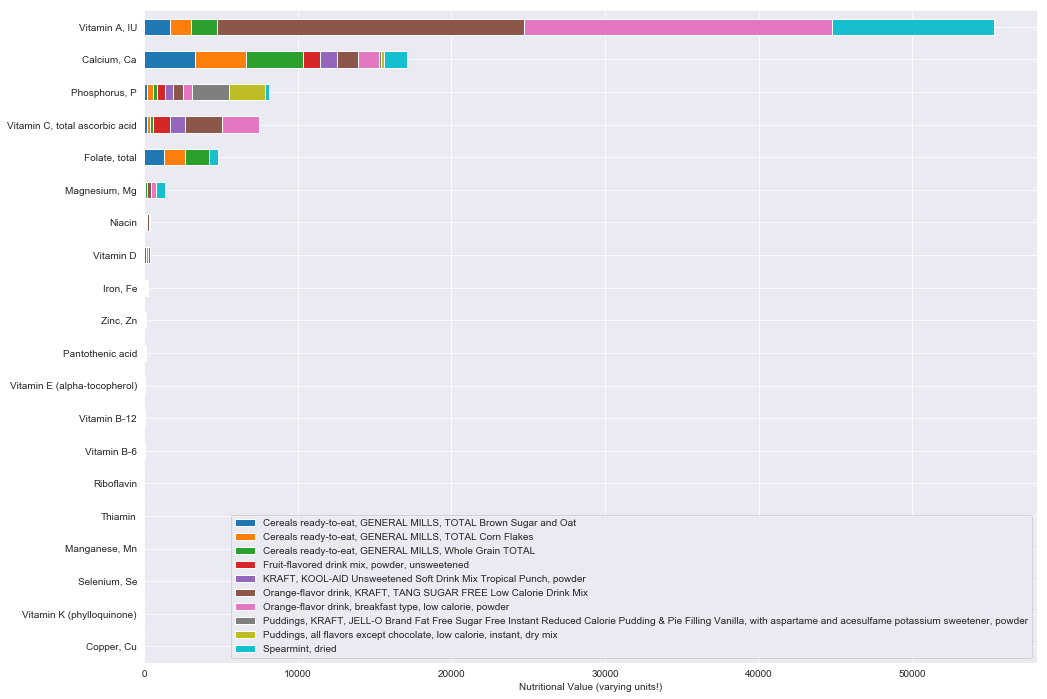

In [14]:
df.T.set_axis(df.food_name, axis=1, inplace=False)\
    .drop(['food_name','food_group'])\
    .assign(temp = lambda f: f.sum(1))\
    .sort_values('temp')\
    .drop('temp', axis=1)\
    .plot.barh(stacked=True)

plt.legend(loc = 'lower right')
plt.xlabel('Nutritional Value (varying units!)');

___Lastly___


Instead of taking the total sum of nutrient values, lets take the __relative distance__ from the recommended daily values mentioned above.

In [16]:
# Most nutritionally balanced foods
df = pd.read_sql(""" 
    -- All combos of foods and specified nutrients
    WITH food_nutrient AS (
        SELECT food_name, nutrient FROM (
            SELECT DISTINCT food_name FROM standardized_quantities
        ) uniq_foods
        CROSS JOIN daily_dose
    )
    -- Select the pct deviance from the recommended values
    SELECT food_name, AVG(pct_diff) AS nutrition_balance_score FROM (
        SELECT 
            food_name, nutrient,  COALESCE(nutrient_val, 0) nutrient_val, recommended_daily_value_mcg, 
            ABS(COALESCE(nutrient_val, 0) - recommended_daily_value_mcg)/recommended_daily_value_mcg AS pct_diff
        -- all values in micrograms
        FROM standardized_quantities sq
        RIGHT JOIN food_nutrient fn USING(food_name, nutrient)
        LEFT JOIN daily_dose dd USING(nutrient)
    ) diff_from_rec
    GROUP BY 1
    ORDER BY 2
    LIMIT 10


        
""", eng)

foods = df.food_name.unique()
df

,food_name,nutrition_balance_score
0,"Cereals ready-to-eat, chocolate-flavored frost...",0.62
1,"Cereals ready-to-eat, KRAFT, POST 100% BRAN Ce...",0.67
2,"Cereals ready-to-eat, GENERAL MILLS, Corn CHEX",0.69
3,"Cereals ready-to-eat, MALT-O-MEAL, Apple Multi...",0.69
4,"Cereals ready-to-eat, GENERAL MILLS, COCOA PUFFS",0.70
5,"Cereals ready-to-eat, KELLOGG, KELLOGG'S RICE ...",0.70
6,"Cereals ready-to-eat, GENERAL MILLS, FRANKENBERRY",0.71
7,"Cereals ready-to-eat, Ralston Crispy Rice",0.71
8,"Cereals ready-to-eat, QUAKER, Cranberry Macada...",0.72
9,"Cereals ready-to-eat, KELLOGG, KELLOGG'S Shred...",0.73


These are the most well balanced foods, containing the closest to the daily recommended values for the given nutrients. Looks like cereal is the way to go!

Let's check the _Normalized_ distribution (scaled to between 0 and 1)

In [17]:
# case statments used to pivot
# Scales all nutrients to between 0 and 1!
case_stmnts = ',\n'.join([
    f"""CASE WHEN nutrient = '{n}' THEN 
        (nutrient_val-MIN(nutrient_val) OVER (PARTITION BY nutrient))/
            (MAX(nutrient_val) OVER (PARTITION BY nutrient) - MIN(nutrient_val) OVER (PARTITION BY nutrient))
        ELSE NULL END AS \"{n}\"
    """
    for n in nutrients
])

# select all nutrients listed previously
agg_stmnt = ','.join([f'SUM("{n}") as "{n}"' for n in nutrients])

df = pd.read_sql(""" 
    SELECT food_name, food_group, {agg_stmnt}
    FROM (
       SELECT food_name, food_group,
           {case_stmts}
       FROM nutr_quantities
       WHERE food_name IN %(foods)s
       AND nutrient IN %(nutrs)s
    ) zscored
    GROUP BY 1,2
""".format(case_stmts=case_stmnts,
           agg_stmnt=agg_stmnt), eng, params={
                'foods':tuple(foods),
                'nutrs':tuple(nutrients)
}).dropna(1,'all')
                 
print(df.shape)
df


(10, 22)


,food_name,food_group,"Calcium, Ca","Copper, Cu","Folate, total","Iron, Fe","Magnesium, Mg","Manganese, Mn",Niacin,Pantothenic acid,"Phosphorus, P",Riboflavin,"Selenium, Se",Thiamin,"Vitamin A, IU",Vitamin B-12,Vitamin B-6,"Vitamin C, total ascorbic acid",Vitamin D,Vitamin E (alpha-tocopherol),Vitamin K (phylloquinone),"Zinc, Zn"
0,"Cereals ready-to-eat, GENERAL MILLS, COCOA PUFFS",Breakfast Cereals,0.77,0.07,0.00,0.34,0.07,0.00,0.32,0.11,0.00,0.26,0.28,0.34,0.00,0.78,0.26,0.31,nan,0.75,1.00,0.86
1,"Cereals ready-to-eat, GENERAL MILLS, Corn CHEX",Breakfast Cereals,0.77,0.83,1.00,0.90,0.07,0.13,0.32,0.00,0.01,0.26,0.45,0.34,0.38,0.78,0.26,0.31,nan,0.60,0.67,0.86
2,"Cereals ready-to-eat, GENERAL MILLS, FRANKENBERRY",Breakfast Cereals,0.15,0.00,0.00,0.34,0.00,0.01,0.32,0.11,0.00,0.26,1.00,0.34,0.00,0.78,0.26,0.31,nan,0.80,1.00,0.86
3,"Cereals ready-to-eat, KELLOGG, KELLOGG'S RICE ...",Breakfast Cereals,0.01,0.13,0.37,0.00,0.06,0.24,0.67,0.30,0.04,0.70,0.58,1.00,0.39,0.95,1.00,0.37,nan,0.20,0.00,0.04
4,"Cereals ready-to-eat, KELLOGG, KELLOGG'S Shred...",Breakfast Cereals,0.09,0.26,0.04,0.75,0.41,1.00,0.36,1.00,0.32,0.30,nan,0.37,nan,0.81,0.27,0.00,nan,nan,nan,0.27
5,"Cereals ready-to-eat, KRAFT, POST 100% BRAN Ce...",Breakfast Cereals,0.17,1.00,0.04,0.82,1.00,nan,0.35,nan,1.00,0.28,nan,0.36,0.59,0.00,0.29,0.00,0.00,nan,nan,0.89
6,"Cereals ready-to-eat, MALT-O-MEAL, Apple Multi...",Breakfast Cereals,1.00,0.06,0.05,0.41,0.10,0.17,0.51,nan,0.08,0.55,0.70,0.38,0.63,1.00,0.69,0.93,1.00,1.00,1.00,1.00
7,"Cereals ready-to-eat, QUAKER, Cranberry Macada...",Breakfast Cereals,0.29,0.24,0.59,0.42,0.21,0.38,0.00,0.41,0.15,0.00,0.00,0.00,0.29,0.00,0.00,0.28,0.35,nan,nan,0.32
8,"Cereals ready-to-eat, Ralston Crispy Rice",Breakfast Cereals,0.00,0.08,0.82,1.00,0.05,0.24,1.00,0.31,0.04,1.00,0.90,0.90,0.53,0.85,0.38,1.00,nan,0.00,0.00,0.05
9,"Cereals ready-to-eat, chocolate-flavored frost...",Breakfast Cereals,0.15,0.19,0.06,0.37,0.10,0.03,0.38,0.10,0.10,0.30,0.28,0.39,1.00,0.82,0.30,0.82,nan,0.25,1.00,0.00


Text(0.5,142,'Nutrient')

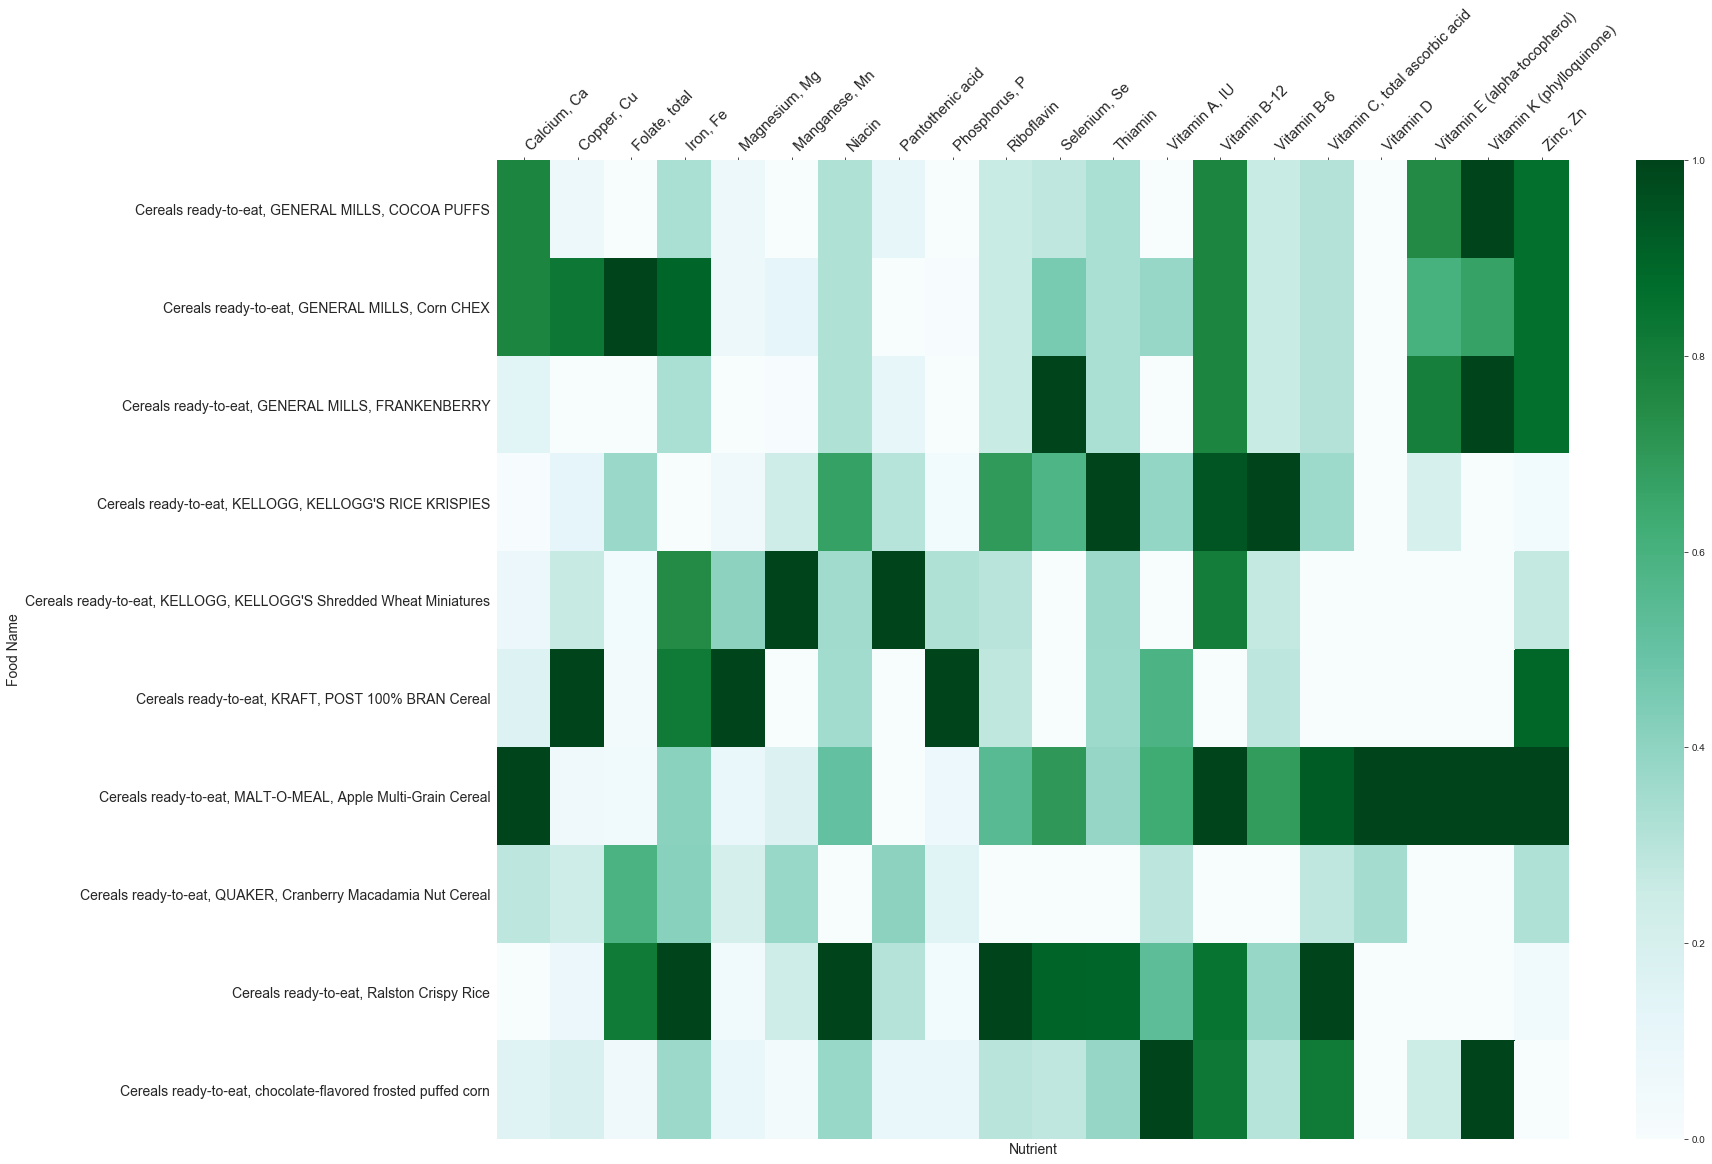

In [18]:
plt.figure(figsize=(24,18))

ax = sns.heatmap(
        df.set_index(['food_name'])
          .drop('food_group', axis=1)
          .fillna(0),
    cmap='BuGn')
ax.xaxis.tick_top()
plt.xticks(rotation=45, ha='left', fontsize=15)
plt.yticks(fontsize=14)
plt.ylabel('Food Name', fontsize=14)
plt.xlabel('Nutrient', fontsize = 14)

Text(0.5,0,'Nutritional Value (varying units!)')

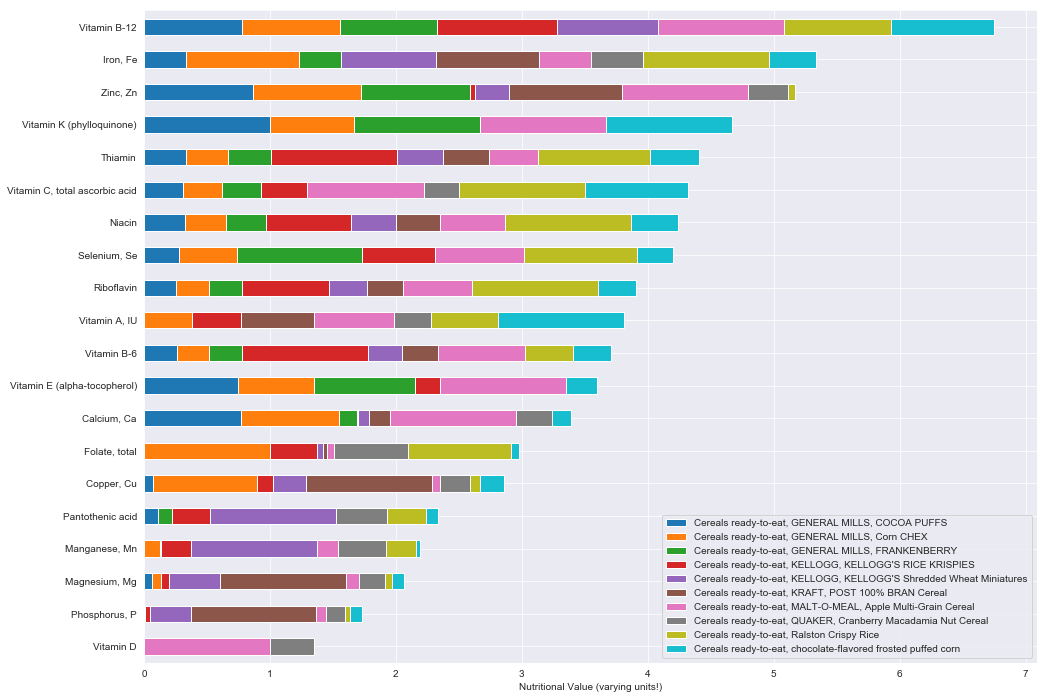

In [19]:
df.T.set_axis(df.food_name, axis=1, inplace=False)\
    .drop(['food_name','food_group'])\
    .assign(temp = lambda f: f.sum(1))\
    .sort_values('temp')\
    .drop('temp', axis=1)\
    .plot.barh(stacked=True)

plt.legend(loc = 'lower right')
plt.xlabel('Nutritional Value (varying units!)')